In [1]:
import pandas as pd
import numpy as np  

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier




%matplotlib inline

In [2]:
tweets = pd.read_csv("trumptweet.csv")
tweets.head()

,source,text,created_at,id_str
0,Twitter for iPhone,RT @JesseBWatters: A new poll has Independents...,11-20-2019 01:51:06,1196969184598675456
1,Twitter for iPhone,A great day for Republicans a great day for ou...,11-20-2019 01:06:48,1196958035127783427
2,Twitter for iPhone,I agree but in the end we will win and save ou...,11-20-2019 00:10:41,1196943910624538625
3,Twitter for iPhone,RT @SenateGOP: It’s time for Democrats to *do ...,11-19-2019 23:57:52,1196940686999851011
4,Twitter for iPhone,RT @RepMarkMeadows: Chairman Schiff is clearly...,11-19-2019 23:32:55,1196934406314889216


In [3]:
for col in tweets.columns: 
    print(col)

source
text
created_at
id_str


In [4]:
tweets.dropna(inplace = True) 
np.array([len(tweets.text) for tweet in tweets])

array([28504, 28504, 28504, 28504])

In [5]:
tweets["Text_Length"]= tweets["text"].str.len() 
tweets.head()


,source,text,created_at,id_str,Text_Length
0,Twitter for iPhone,RT @JesseBWatters: A new poll has Independents...,11-20-2019 01:51:06,1196969184598675456,140
1,Twitter for iPhone,A great day for Republicans a great day for ou...,11-20-2019 01:06:48,1196958035127783427,56
2,Twitter for iPhone,I agree but in the end we will win and save ou...,11-20-2019 00:10:41,1196943910624538625,105
3,Twitter for iPhone,RT @SenateGOP: It’s time for Democrats to *do ...,11-19-2019 23:57:52,1196940686999851011,102
4,Twitter for iPhone,RT @RepMarkMeadows: Chairman Schiff is clearly...,11-19-2019 23:32:55,1196934406314889216,138


Above, we have added code to figure out the length of each tweet in tweets

There are outliers present; We have to remove the outliers. 

In [6]:
from scipy import stats
tweets=tweets[np.abs(tweets.Text_Length-tweets.Text_Length.mean()) <= (3*tweets.Text_Length.std())]
tweets.reset_index(inplace = True) 
tweets.tail()

,index,source,text,created_at,id_str,Text_Length
28398,28499,Twitter for Android,@ma22dogs: @realDonaldTrump @TrumpLasVegas the...,01-02-2014 06:03:17,418623509838192640,242
28399,28500,Twitter for Android,@noahshappy: @realDonaldTrump very true commen...,01-02-2014 06:02:48,418623389600083968,107
28400,28501,Twitter for Android,@MeleMallory: @realDonaldTrump You know it's a...,01-02-2014 05:47:30,418619537740017664,254
28401,28502,Twitter for Android,This very expensive GLOBAL WARMING bullshit ha...,01-02-2014 00:39:56,418542137899491328,138
28402,28503,Twitter for Android,Today is the first day of the rest of your lif...,01-01-2014 12:56:30,418365112844824577,70


In [7]:
Tweet_lengths = pd.Series(data=tweets['Text_Length'].values, index=tweets['created_at'])
Tweet_lengths.describe()

count    28403.000000
mean       140.454353
std         69.435507
min          2.000000
25%        100.000000
50%        133.000000
75%        140.000000
max        604.000000
dtype: float64

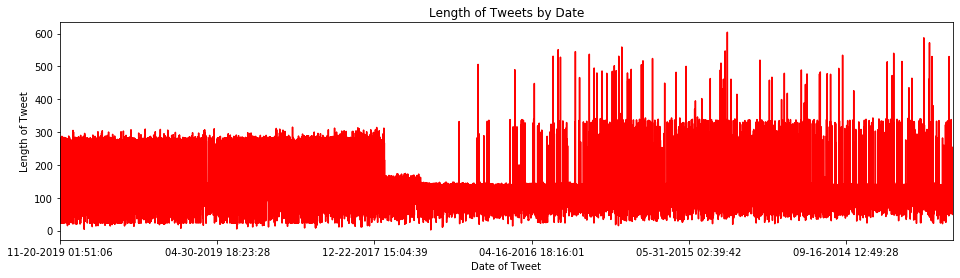

In [8]:
Tweet_lengths.plot(figsize=(16,4), color='r')
plt.xlabel('Date of Tweet')
plt.ylabel('Length of Tweet')
plt.title("Length of Tweets by Date")
plt.show()

In [9]:
sources = []
for source in tweets['source']:
    if source not in sources:
        sources.append(source)
        
print("Content sources:")
for source in sources:
    print("* {}".format(source))

Content sources:
* Twitter for iPhone
* Twitter Media Studio
* Twitter Web App
* Twitter Web Client
* Twitter for iPad
* Media Studio
* Twitter Ads
* Twitter for Android
* Periscope
* TweetDeck
* Instagram
* Mobile Web (M5)
* Twitter Mirror for iPad
* Twitter QandA
* Facebook
* Twitter for BlackBerry
* Neatly For BlackBerry 10
* Twitter for Websites
* Twitlonger


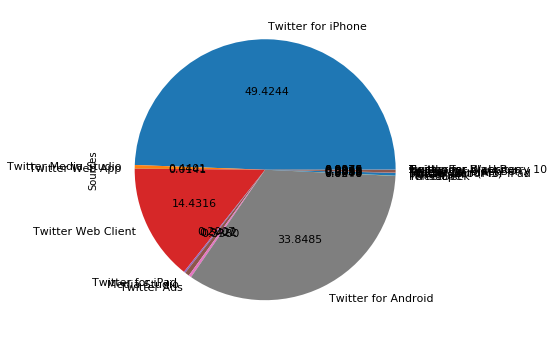

In [10]:
percent = np.zeros(len(sources))

for source in tweets['source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

percent /= 100

# Pie chart:
pie_chart = pd.Series(percent, index=sources, name='Sources')
pie_chart.plot.pie(fontsize=11, autopct='%.4f', figsize=(6, 6));

In [11]:
tweets['created_at']= pd.to_datetime(tweets['created_at']) 
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28403 entries, 0 to 28402
Data columns (total 6 columns):
index          28403 non-null int64
source         28403 non-null object
text           28403 non-null object
created_at     28403 non-null datetime64[ns]
id_str         28403 non-null int64
Text_Length    28403 non-null int64
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 1.3+ MB


In [12]:
from textblob import TextBlob
import re

def clean_tweet(tweet):
    '''
    Use re to remove special characers and keep only the necessary characters. 
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    '''
    Classify whether a tweet is positive or negative using polarity for cleaned tweets
    '''
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [13]:
tweets['cleaned'] = np.array([ clean_tweet(tweet) for tweet in tweets['text'] ])

In [14]:
tweets['sentiment'] = np.array([ analize_sentiment(tweet) for tweet in tweets['text'] ])


In [15]:
tweets.tail()

,index,source,text,created_at,id_str,Text_Length,cleaned,sentiment
28398,28499,Twitter for Android,@ma22dogs: @realDonaldTrump @TrumpLasVegas the...,2014-01-02 06:03:17,418623509838192640,242,the rooms are like condos Perfect for families...,1
28399,28500,Twitter for Android,@noahshappy: @realDonaldTrump very true commen...,2014-01-02 06:02:48,418623389600083968,107,very true comment Donald I m glad we have peop...,1
28400,28501,Twitter for Android,@MeleMallory: @realDonaldTrump You know it's a...,2014-01-02 05:47:30,418619537740017664,254,You know it s actually called CLIMATE CHANGE r...,1
28401,28502,Twitter for Android,This very expensive GLOBAL WARMING bullshit ha...,2014-01-02 00:39:56,418542137899491328,138,This very expensive GLOBAL WARMING bullshit ha...,-1
28402,28503,Twitter for Android,Today is the first day of the rest of your lif...,2014-01-01 12:56:30,418365112844824577,70,Today is the first day of the rest of your lif...,1


In [16]:
positive = [ tweet for index, tweet in enumerate(tweets['text']) if tweets['sentiment'][index] > 0]
neutral = [ tweet for index, tweet in enumerate(tweets['text']) if tweets['sentiment'][index] == 0]
negative = [ tweet for index, tweet in enumerate(tweets['text']) if tweets['sentiment'][index] < 0]

In [17]:
print("Positive tweets: {}%".format(len(positive)*100/len(tweets['text'])))
print("Neutral tweets: {}%".format(len(neutral)*100/len(tweets['text'])))
print("Negative tweets: {}%".format(len(negative)*100/len(tweets['text'])))

Positive tweets: 55.07516811604408%
Neutral tweets: 26.571136851741013%
Negative tweets: 18.353695032214908%


In [18]:
tweets['date'] = tweets['created_at'].dt.date
tweets["Date"] = tweets['created_at'].dt.date

tweets = tweets.groupby(by='date').count()

In [19]:
tweets['count']= tweets['created_at']
mean_tweets = tweets['count'].mean()
print(mean_tweets)


13.525238095238095


## After a small sneak peak, we shall begin the bulk of our analysis
Let us start by changing the way we perform a sentiment analysis while also utilizing more data from Trump's Tweets

In [20]:
tweets = pd.read_csv("Data/trumptweets.csv", header=0,encoding = 'unicode_escape') #Updated Tweet data
tweets.head()

,text,created_at,retweet_count,favorite_count
0,https://t.co/ruQBK6gNLL,12-11-2019 03:07:09,10796,32898
1,After years of rebuilding OTHER NATIONS we are...,12-11-2019 01:58:47,17977,67555
2,Day after day we are exposing the depravity di...,12-11-2019 01:55:19,17724,62825
3,THANK YOU PENNSYLVANIA! With your help your de...,12-11-2019 01:47:49,26458,90566
4,Just had a very good meeting with Foreign Mini...,12-10-2019 22:51:30,10372,42238


In [21]:
stock1 = pd.read_csv('Data/historical.csv')
stock2 = pd.read_csv('Data/historical2.csv')
stock3 = pd.read_csv('Data/historical3.csv')
stock4 = pd.read_csv('Data/historical4.csv')
stock5 = pd.read_csv('Data/historical5.csv')
stock6 = pd.read_csv('Data/historical6.csv')
stock_df = stock1.append([stock2,stock3,stock4,stock5,stock6])
stock_df.head()

,Symbol,Date,Open,High,Low,Close,Volume,Change,% Change
0,SPX,12/31/14,2082.0,2059.0,2059.0,2059,2606070000,-21.45,-1.03%
1,SPX,12/30/14,2088.0,2088.0,2080.0,2080,0,-10.22,-0.49%
2,SPX,12/29/14,2088.0,2094.0,2086.0,2091,0,1.80,0.09%
3,SPX,12/26/14,2084.0,2093.0,2084.0,2089,0,6.89,0.33%
4,SPX,12/24/14,2083.0,2082.0,2082.0,2082,1416980000,-0.29,-0.01%


In [22]:
trim_df = stock_df[['Date', 'Open']]
trim_df['pure_date'] = trim_df.Date

C:\Users\dhruv\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
change = []
for item in stock_df.Change:
    if item > 0:
        change.append(1)
    else:
        change.append(-1)
trim_df['Change'] = change
trim_df

C:\Users\dhruv\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,Date,Open,pure_date,Change
0,12/31/14,2082.0,12/31/14,-1
1,12/30/14,2088.0,12/30/14,-1
2,12/29/14,2088.0,12/29/14,1
3,12/26/14,2084.0,12/26/14,1
4,12/24/14,2083.0,12/24/14,-1
5,12/23/14,2081.0,12/23/14,1
6,12/22/14,2069.0,12/22/14,1
7,12/19/14,2061.0,12/19/14,1
8,12/18/14,2019.0,12/18/14,1
9,12/17/14,1974.0,12/17/14,1


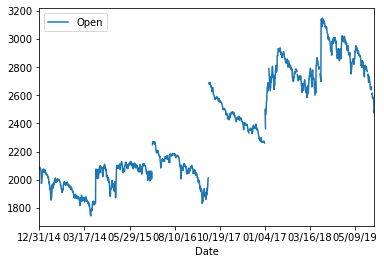

In [24]:
stock_df.plot('Date','Open')


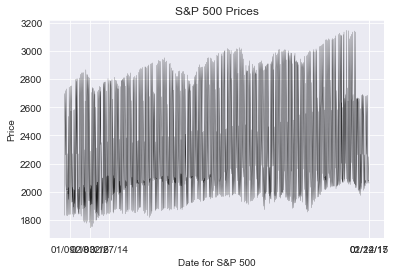

In [25]:
sns.set_style('darkgrid')
ax = sns.lineplot(x=trim_df.pure_date,y=trim_df.Open, linewidth=0.2,color='black')
ax.set(title='S&P 500 Prices',
       xlabel='Date for S&P 500',
       xticks=['02/27/14', '02/14/15', '02/03/16', '01/22/17', '01/09/18'],
      ylabel='Price')
plt.show()

In [26]:
sentences = tweets['text'].tolist()

In [27]:
analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)

Here we have to use a sentiment classifier

tweets['sentiment'] = vs['compound'] 

In [28]:
tweets[['sentiment', 'subjectivity']] = tweets['text'].apply(lambda text: pd.Series(TextBlob(text).sentiment))


In [29]:
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# sid = SentimentIntensityAnalyzer()
# tweets["sentimentscore"] = tweets.apply(lambda row: sid.polarity_scores(row['text'])['compound'] , axis=1)

In [30]:
tweets.head()

,text,created_at,retweet_count,favorite_count,sentiment,subjectivity
0,https://t.co/ruQBK6gNLL,12-11-2019 03:07:09,10796,32898,0.00000,0.000000
1,After years of rebuilding OTHER NATIONS we are...,12-11-2019 01:58:47,17977,67555,0.06250,0.569444
2,Day after day we are exposing the depravity di...,12-11-2019 01:55:19,17724,62825,-0.18750,0.700000
3,THANK YOU PENNSYLVANIA! With your help your de...,12-11-2019 01:47:49,26458,90566,0.78125,0.750000
4,Just had a very good meeting with Foreign Mini...,12-10-2019 22:51:30,10372,42238,0.27700,0.386000


In [31]:
tweets['date']= pd.to_datetime(tweets['created_at']) 

In [32]:
tweets['just_date'] = tweets['date'].dt.date

In [33]:
tweets.head()

,text,created_at,retweet_count,favorite_count,sentiment,subjectivity,date,just_date
0,https://t.co/ruQBK6gNLL,12-11-2019 03:07:09,10796,32898,0.00000,0.000000,2019-12-11 03:07:09,2019-12-11
1,After years of rebuilding OTHER NATIONS we are...,12-11-2019 01:58:47,17977,67555,0.06250,0.569444,2019-12-11 01:58:47,2019-12-11
2,Day after day we are exposing the depravity di...,12-11-2019 01:55:19,17724,62825,-0.18750,0.700000,2019-12-11 01:55:19,2019-12-11
3,THANK YOU PENNSYLVANIA! With your help your de...,12-11-2019 01:47:49,26458,90566,0.78125,0.750000,2019-12-11 01:47:49,2019-12-11
4,Just had a very good meeting with Foreign Mini...,12-10-2019 22:51:30,10372,42238,0.27700,0.386000,2019-12-10 22:51:30,2019-12-10


In [34]:
trim_df['date']= pd.to_datetime(trim_df['Date']) 
trim_df['just_date'] = trim_df['date'].dt.date

C:\Users\dhruv\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\dhruv\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [35]:
trim_df.head()

,Date,Open,pure_date,Change,date,just_date
0,12/31/14,2082.0,12/31/14,-1,2014-12-31,2014-12-31
1,12/30/14,2088.0,12/30/14,-1,2014-12-30,2014-12-30
2,12/29/14,2088.0,12/29/14,1,2014-12-29,2014-12-29
3,12/26/14,2084.0,12/26/14,1,2014-12-26,2014-12-26
4,12/24/14,2083.0,12/24/14,-1,2014-12-24,2014-12-24


In [36]:
combined= pd.merge(trim_df, tweets, on='just_date')

In [37]:
combined.head()

,Date,Open,pure_date,Change,date_x,just_date,text,created_at,retweet_count,favorite_count,sentiment,subjectivity,date_y
0,12/31/14,2082.0,12/31/14,-1,2014-12-31,2014-12-31,To EVERYONE including all haters and losers HA...,12-31-2014 21:15:21,1271,1209,0.213997,0.598178,2014-12-31 21:15:21
1,12/31/14,2082.0,12/31/14,-1,2014-12-31,2014-12-31,In the end you're measured not by how much you...,12-31-2014 15:52:44,283,325,0.100000,0.600000,2014-12-31 15:52:44
2,12/31/14,2082.0,12/31/14,-1,2014-12-31,2014-12-31,Without passion you don't have energy without ...,12-31-2014 15:50:39,507,562,0.500000,0.600000,2014-12-31 15:50:39
3,12/31/14,2082.0,12/31/14,-1,2014-12-31,2014-12-31,If you're interested in 'balancing' work and p...,12-31-2014 15:45:09,360,441,0.375000,0.500000,2014-12-31 15:45:09
4,12/30/14,2088.0,12/30/14,-1,2014-12-30,2014-12-30,What separates the winners from the losers is ...,12-30-2014 21:50:40,580,512,-0.031818,0.327273,2014-12-30 21:50:40


In [38]:
combined.describe()

,Open,Change,retweet_count,favorite_count,sentiment,subjectivity
count,14890.000000,15249.000000,15249.000000,15249.000000,15249.000000,15249.000000
mean,2433.922901,0.069841,11596.584629,42428.781166,0.148702,0.422051
std,417.085125,0.997591,12447.646398,49266.623429,0.343383,0.303114
min,1744.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000
25%,2054.000000,-1.000000,1193.000000,352.000000,0.000000,0.100000
50%,2391.000000,1.000000,9779.000000,22605.000000,0.045455,0.468056
75%,2861.000000,1.000000,18081.000000,74594.000000,0.343750,0.650000
max,3147.000000,1.000000,344806.000000,879647.000000,1.000000,1.000000


#### This chunk of code below is optional, but it is so we can analyze the stock price the day after the tweet was sent.
For our purpose, we shall observe changes/fluctuations on the same day

In [39]:

# pure_date = []           
# for item in tweets.date:
#     try:
#         pure_date.append(datetime.date(year=item.year, month=item.month, day=item.day+1))
#     except:
#         pure_date.append(datetime.date(year=item.year, month=item.month+1, day=1))
#     else:
#         pass

In [40]:
df = combined.drop(['Date','Open','pure_date', 'date_x', 'text' , "created_at", 'date_y', 'just_date'], axis=1)
df.head(10)

,Change,retweet_count,favorite_count,sentiment,subjectivity
0,-1,1271,1209,0.213997,0.598178
1,-1,283,325,0.100000,0.600000
2,-1,507,562,0.500000,0.600000
3,-1,360,441,0.375000,0.500000
4,-1,580,512,-0.031818,0.327273
5,-1,447,499,0.468182,0.427273
6,-1,139,189,0.000000,0.000000
7,-1,27,46,0.500000,0.400000
8,-1,47,82,-0.075000,0.350000
9,-1,583,659,0.700000,0.800000


## Now we can Start the modelling aspect

We shall use the processed dataframe from above to model several aspects

In [41]:
X = df.drop(['Change'], axis=1)
y = df['Change']

In [42]:
X.head()

,retweet_count,favorite_count,sentiment,subjectivity
0,1271,1209,0.213997,0.598178
1,283,325,0.100000,0.600000
2,507,562,0.500000,0.600000
3,360,441,0.375000,0.500000
4,580,512,-0.031818,0.327273


In [43]:
y.head(15)

0    -1
1    -1
2    -1
3    -1
4    -1
5    -1
6    -1
7    -1
8    -1
9    -1
10    1
11    1
12    1
13    1
14    1
Name: Change, dtype: int64

In [44]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25, shuffle=False)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
model_set_1 = [LogisticRegression()]
grid = {'C':np.logspace(-3,2,10)}
for model in model_set_1:
    gscv = GridSearchCV(model,param_grid=grid,n_jobs=-1,cv=10)
    gscv.fit(X_train,y_train)
    print(gscv.best_estimator_)
    print(gscv.best_score_)



LogisticRegression(C=0.003593813663804626, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
0.5269324938789787


C:\Users\dhruv\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [46]:
model_set_2 = KNeighborsClassifier()
grid={'n_neighbors' : range(2,50,1)}
gscv2 = GridSearchCV(model_set_2,param_grid=grid,n_jobs=-1,cv=10)
gscv2.fit(X_train,y_train)
print(gscv2.best_estimator_)
print(gscv2.best_score_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
0.48382301504022385


In [47]:
model_set_3 = [DecisionTreeClassifier()]
grid = {}
for model in model_set_3:
    gscv3 = GridSearchCV(model,param_grid=grid,n_jobs=-1,cv=10)
    gscv3.fit(X_train,y_train)
    print(gscv3.best_estimator_)
    print(gscv3.best_score_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.48723329835606854


### Explained
From the above cross validation tests and scores, we can clearly see that logistic regression performs the best, followed by the decision tree classifier, then followed by the KNN classifier. 

Logistic Regression with a 10 fold cross validation gives us a score of 0.5269324938789787

DecisionTreeClassifier with cv of 10 gives us a score of 0.4863588667366212, less than a coin toss. 

KNeighborsClassifier with a cv of 10 gives us a score of  0.48382301504022385 which is only very slightly under the Decision tree classifier. This is a little less than a coin toss. 

### Test set evaluation of Trump on S&P 500 Market Data

First, we shall test the simple Logistic Regression classifier on our test dataset. 
From our previous iterations on test set, we saw that Logistic Regression performed the best. 

In [48]:
top = 0
for i in np.logspace(-3,2,10):
    logreg = LogisticRegression(C=i)
    logreg.fit(X_train,y_train)
    if logreg.score(X_test,y_test)>top:
        top = logreg.score(X_test,y_test)
        top_i = i
print('LOGREG - C=', top_i)
print('Accuracy:',top)
print()

LOGREG - C= 0.01291549665014884
Accuracy: 0.5601888276947286



C:\Users\dhruv\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dhruv\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dhruv\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dhruv\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dhruv\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [49]:
top=0
for i in range(2,50):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    if knn.score(X_test,y_test) > top:
        top=knn.score(X_test,y_test)
        top_i = i
print(f'KNN with {top_i} Neighbors - Accuracy:', top)
print()


KNN with 47 Neighbors - Accuracy: 0.5226855494361395



In [50]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
print('Decision Tree Accuracy:', dt.score(X_test,y_test))
print()

Decision Tree Accuracy: 0.5048518227117755



Clearly, we can see that the logistic regression function and model performed the best and is more than 10% accurate in comparison to a coin toss. 

### Further exploration
On Kaggle and as described in lecture, we can see that the XGBoost model classifier is continually winning competitions and seems to be a good fit. 

Let us see if the algorithm can help us predict our data any better. 

In [51]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix

kf = KFold(n_splits=5, shuffle=False)
mat_list = []
for train_index, test_index in kf.split(X):
    X_train1 = X.iloc[train_index]
    y_train1 = y[train_index]
    xgb_model = xgb.XGBClassifier().fit(X_train1,y_train1)
    predictions = xgb_model.predict(X.iloc[test_index])
    actuals = y[test_index]
    mat_list.append(confusion_matrix(actuals, predictions))
matrix = mat_list[0]
for n_mat in range(1,5):
    for i in range(2):
        for j in range(2):
            matrix[i][j] += mat_list[n_mat][i][j]
true = matrix[0][0] + matrix[1][1]
false = matrix[1][0] + matrix[0][1]
print('XGB performance', true/(true+false))

XGB performance 0.5170175093448751


In [52]:
xgb_model = xgb.XGBClassifier().fit(X_train,y_train)
predictions = xgb_model.predict(X_test)
actuals = y_test


In [53]:
print('XGB Accuracy', xgb_model.score(X_test,y_test))


XGB Accuracy 0.5481248360870705


In [54]:
print(confusion_matrix(actuals, predictions))

[[ 186 1504]
 [ 219 1904]]


### Fin